### Preprocess the data

Next, we need to transform our simulation data into .csv files containing the data we need for our simulations. We can do that using the `preprocess_file` function in the file `preprocess.py`.

In [1]:
import os
import shutil

from spatz.utils.preprocess import preprocess_file


PATH = 'data/simulations/'

# Delete the old folder of preprocessed files.
if os.path.isdir(PATH + 'temp/'):
    shutil.rmtree(PATH + 'temp/')

# Create the folder again.
os.mkdir(PATH + 'temp/')

# Preprocess the files.
for file in os.listdir(PATH):
    if not os.path.isdir(PATH + file) and '.txt' in file:
        df = preprocess_file(PATH + file)
        df.to_csv(PATH + 'temp/' + file.replace('.txt', '.csv'))

### Setup the simulation

First we have to create a simulation instance and specify how we want to iterate through the simulation. We choose to sample data every 0.1 seconds.

In addition, there is the option to add delays in the sampling by adding Gaussian noise to the sampling rate. In this case data might be sampled after 0.1 + noise seconds.

In [2]:
from spatz.simulation import Simulation, UniformTimeSteps

# Construct a time model.
timesteps = UniformTimeSteps(0.1, mu=0, sigma=0, delay_only=True)

# Construct a simulation instance with the time model.
simulation = Simulation(timesteps)

Next, we need to specify the sensors we are using. For this demo we are using the sensors used by Aquila's CAPUT v4. We call `simulation.add_sensor` with the sensor class as an argument to register and create a sensor for the simulation. This allows the sensor to fetch the data.

In [3]:
from spatz.sensors.imu.wsen_isds import WSEN_ISDS_ACC, WSEN_ISDS_GYRO
from spatz.sensors.pressure.ms5611_01ba03 import MS5611_01BA03
from spatz.sensors.gps.erinome1 import Erinome_I

press_sensor = simulation.add_sensor(MS5611_01BA03)

# Use the offset argument to change the position of the imu in relation to the rocket's center of gravity.
accelerometer = simulation.add_sensor(WSEN_ISDS_ACC, offset=0)
gyro = simulation.add_sensor(WSEN_ISDS_GYRO, offset=0)

# Add a GPS module to the simulation which returns the following data: [latitude, longitude, altitude (km)]
gps_module = simulation.add_sensor(Erinome_I)

Since we are not only interested in obtaining sensor measurements but also want certain ground truth values, we need to register so-called `Observer` objects. `Observer`s are simular to sensors but don't add any noise or other transformations to the data. Instead, when called they just return the correct values and write them to the logger.

In this demo we will just observe the rocket's altitude in order to compare it with our model's estimation.

In [4]:
altitude = simulation.add_observer(['altitude'])

### Run the simulation

With everything set up, we can load the dataset we want to explore.

In [5]:
simulation.load(PATH + 'temp/' + '7km.csv')

The simulation class has a function `run` which allows us to loop through every time step. The returned values are the index of the current step, the time of the current step and the change in time since the last time step.

In each iteration we can call the sensors like functions to obtain the measurements at the current time steps. Please note that calling sensors multiple times at the same time steps may result in different measurements.

In [6]:
logger = simulation.get_logger()

# Set verbose to False to disable the progress bar
for step, t, dt in simulation.run(verbose=True):
    # Get the sensor data for the current time
    press = press_sensor()
    acc = accelerometer()
    rot_rate = gyro()
    gps = gps_module()

    # Get the correct altitude data.
    alt = altitude()

    # TODO: Add your computation here.

  1%|          | 3.3000000000000016/345.0 [00:00<00:31, 10.80it/s]

100%|█████████▉| 344.9000000000099/345.0 [00:47<00:00,  7.33it/s] 


In [7]:
df = logger.get_dataframe()

df

time MS5611_01BA03/ts_effects mach/mach_no mach/speedofsound  \
0       0.1                      0.0     0.007016        339.067143   
1       0.2                      0.0     0.013913        339.065795   
2       0.3                      0.0     0.020692        339.063569   
3       0.4                      0.0     0.027351        339.060477   
4       0.5                      0.0     0.033927        339.056534   
...     ...                      ...          ...               ...   
3444  344.5                      0.0     0.015286        339.111824   
3445  344.6                      0.0     0.015286         339.11382   
3446  344.7                      0.0     0.015285        339.115816   
3447  344.8                      0.0     0.015285        339.117812   
3448  344.9                      0.0     0.015284        339.119808   

     MS5611_01BA03/noise MS5611_01BA03/out WSEN_ISDS_ACC/FL_x  \
0              -0.018387        975.480091               -0.0   
1               0.512119        975.969833               -0.0   
2              -2.260561        973.129825               -0.0   
3               0.722061        976.018948                0.0   
4               0.400507        975.578178               -0.0   
...                  ...               ...                ...   
3444           -0.531794        976.318784               -0.0   
3445            1.496568        978.407596               -0.0   
3446           -0.387131        976.584349               -0.0   
3447            0.392596        977.424527               -0.0   
3448           -0.013876        977.078506               -0.0   

     WSEN_ISDS_ACC/FL_y WSEN_ISDS_ACC/FL_z WSEN_ISDS_ACC/B_x  ...  \
0              4.044397          23.256113        -32.577163  ...   
1               3.97431          22.853091        -32.180101  ...   
2              3.903998          22.448775        -31.781763  ...   
3               3.83641          22.060123        -31.398858  ...   
4              3.808092           21.89728        -31.238423  ...   
...                 ...                ...               ...  ...   
3444                0.0           0.001295         -0.012063  ...   
3445                0.0           0.001295         -0.012063  ...   
3446                0.0           0.001295         -0.012063  ...   
3447                0.0           0.001295         -0.012063  ...   
3448                0.0           0.001295         -0.012063  ...   

     WSEN_ISDS_ACC/out_0 WSEN_ISDS_ACC/out_1 WSEN_ISDS_ACC/out_2  \
0              32.574601           -4.081343           -5.725432   
1                32.2092           -3.986376           -5.665523   
2              31.811645            -3.93001           -5.484266   
3              31.417342           -3.875468           -5.482977   
4              31.165447           -3.815917           -5.545503   
...                  ...                 ...                 ...   
3444            0.048509            0.059759           -9.807724   
3445              0.0775            0.014265           -9.828498   
3446           -0.055745            -0.00512             -9.8085   
3447           -0.002507           -0.021518           -9.813728   
3448           -0.047244            0.022966           -9.780433   

     WSEN_ISDS_GYRO/out_0 WSEN_ISDS_GYRO/out_1 WSEN_ISDS_GYRO/out_2  \
0                     0.0                  0.0                  0.0   
1                     0.0                  0.0                  0.0   
2                     0.0                  0.0                  0.0   
3                     0.0                  0.0                  0.0   
4                     0.0                  0.0                  0.0   
...                   ...                  ...                  ...   
3444                  0.0                  0.0                  0.0   
3445                  0.0                  0.0                  0.0   
3446                  0.0                  0.0                  0.0   
3447             

### Do your research

In [9]:
import matplotlib.pyplot as plt

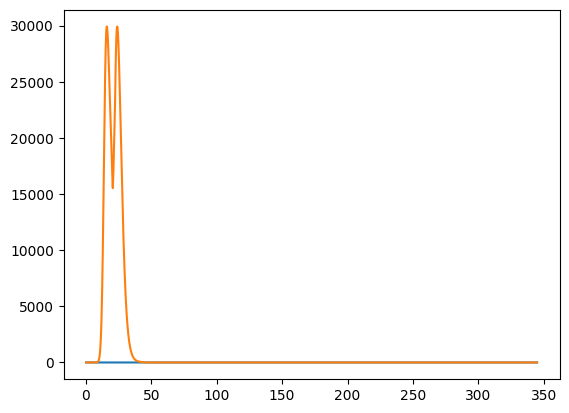

In [10]:
plt.plot(df['time'][1:], df['mach/mach_no'][1:], label='mach number')
plt.plot(df['time'][1:], df['MS5611_01BA03/ts_effects'][1:], label='ts effects')
plt.show()

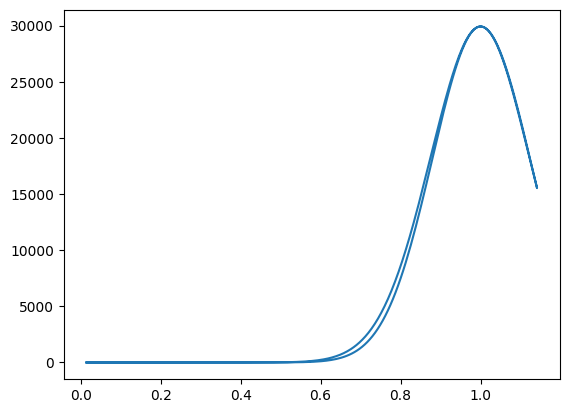

In [11]:
plt.plot(df['mach/mach_no'][1:], df['MS5611_01BA03/ts_effects'][1:])
plt.show()

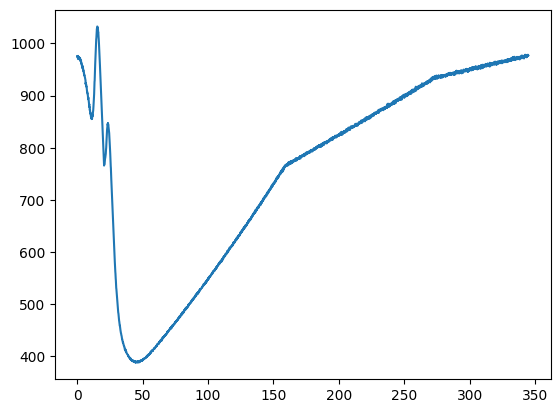

In [12]:
plt.plot(df['time'][1:], df['MS5611_01BA03/out'][1:])
plt.show()

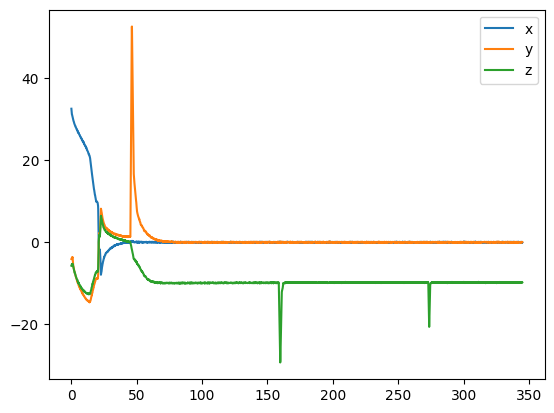

In [13]:
plt.plot(df['time'], df['WSEN_ISDS_ACC/out_0'], label='x')
plt.plot(df['time'], df['WSEN_ISDS_ACC/out_1'], label='y')
plt.plot(df['time'], df['WSEN_ISDS_ACC/out_2'], label='z')
plt.legend()
plt.show()